In [1]:
suppressWarnings(require('pkgmaker',quietly = T))
require('plyr',quietly = T)
l_ply(c('dplyr',
        'plotly',
        'data.table',
#         'jsonlite', 
#         'rjson',
#         'httr',
        'tidyr',  
        'reshape2',
        'factoextra',
        'kableExtra',
        'parallel',
        'doParallel',
        'scales',
        'StatMatch',
        'lattice',
        'utils',
        'missMDA',
        'RMariaDB',
        'pacman',
        'parmigene',
        'matrixTests',
        'hablar',
        'tibble', 
        'DEqMS', 
        'pcaMethods'), function(pkg) {
          invisible(capture.output(irequire(pkg, quiet = T, autoinstall = T)))
        })

## Example data

In [2]:
# url <- "https://ftp.ebi.ac.uk/pride-archive/2016/06/PXD004163/Yan_miR_Protein_table.flatprottable.txt"
# download.file(url, destfile = "./data/miR_Proteintable.txt",method= "auto")

df.prot = read.table("./data/miR_Proteintable.txt",stringsAsFactors = FALSE,
                     header = TRUE, quote = "", comment.char = "",sep = "\t")
head(df.prot, 2)

In [3]:
TMT_columns = seq(15,33,2)
dat = df.prot[df.prot$miR.FASP_q.value<0.01,TMT_columns]
rownames(dat) = df.prot[df.prot$miR.FASP_q.value<0.01,]$Protein.accession
rm(df.prot) # release memory since using dat from here on
head(dat, 2)

In [9]:
dat.log = log2(dat)
#remove rows with NAs
dat.log = na.omit(dat.log)

In [10]:
# Define a vector with the treatment group in the same order as samples in the protein table.
cond = as.factor(c("ctrl","miR191","miR372","miR519","ctrl",
"miR372","miR519","ctrl","miR191","miR372"))

## Protein_intensity table

From /general_analysis/DataBaseUpload/NGS/Proteomics/bin/PhosphoProteomics_PreProccess.html:

Outlayiers: very low/high values (0.0001% and 99.9999%) were floored to these ranges. This believed to be an error and unlikely to be real value.

Possible reason: the original data have Inf. The R language calculated it to some extreme values.

In [38]:
# from /general_analysis/DataBaseUpload/NGS/Proteomics/bin/PhosphoProteomics_PreProccess.html
# `Counts` are just 2 to the power of Intensity. This is for DE analysis where counts are needed
# note: without filtering, the dimension is 1330824 rows
intensity <- read.csv("../proteomics/data/Protein_intensity.csv") 
# %>% filter(Intensity > -3.0) # remove values that are too small - think if this is necessary

In [3]:
int_mtx <- intensity %>% 
    select(c('ProteinGroup', 'Sample', 'Intensity'))  %>% 
    pivot_wider(names_from = Sample, values_from = Intensity, values_fn = mean) %>% 
#     pivot_wider(names_from = Sample, values_from = Intensity) %>% 
    column_to_rownames('ProteinGroup')
# head(int_mtx)
# print(dim(int_mtx))
# rm(intensity)  # release memory since using int_mtx from here on

In [15]:
# If omitting all proteins with NA values, how many rows are left?
x <- na.omit(int_mtx)
dim(x)

[1] 295 317

In [16]:
# proportion of missin values
sum(is.na(int_mtx))/(dim(int_mtx)[1] * dim(int_mtx)[2])

[1] 0.5097888

The intensity is already in log-scale because it has negative values.

### Check the distribution of non-missing values

Missing values in proteomic data can be generally characterized into missing at random (MAR) and missing not at random (MNAR). 
+ MAR missing values mostly result from technical limitations and stochastic fluctuations in an abundance-independent manner.
+ MNAR missing values are more abundance-dependent that can be explained by the measurability of the corresponding peptides. 

Missing values in proteomic data are a mixture of MAR and MNAR. Although the real proportion is difficult to determine, it is believed that MNAR plays a dominant role in producing missing values.

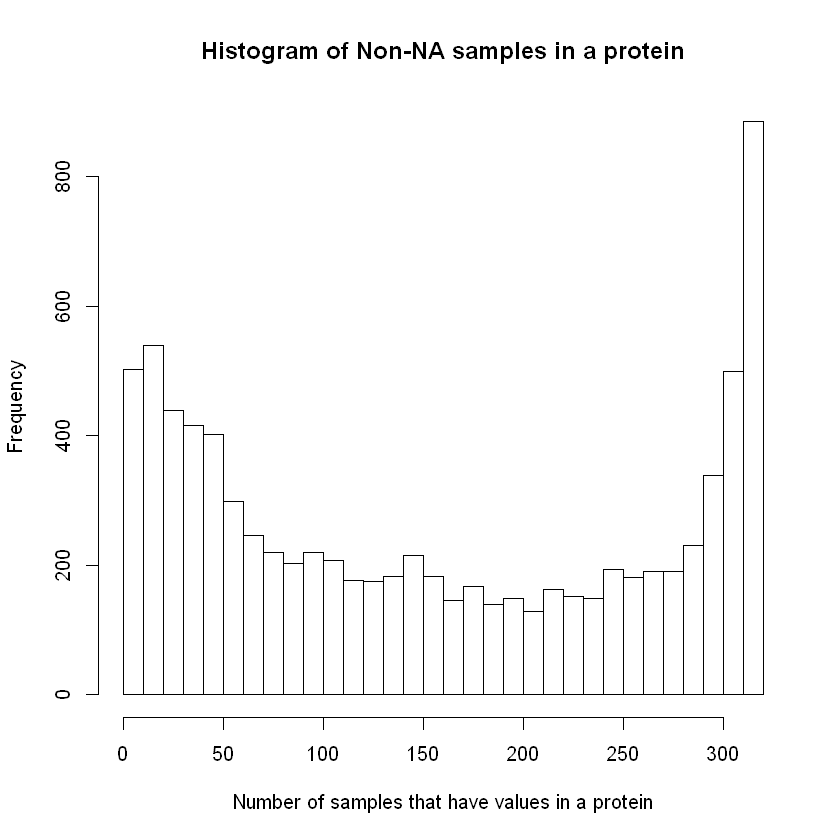

In [17]:
# For each protein group, how many samples have intensity values
hist(rowSums(!is.na(int_mtx)), breaks = 30,
     main = "Histogram of Non-NA samples in a protein",
     xlab = "Number of samples that have values in a protein")  

In [18]:
# For each sample, how many protein groups have intensity values
hist(colSums(!is.na(int_mtx)), breaks = 18,
     main = "Histogram of Non-NA proteins in a sample",
     xlab = "Number of proteins that have values in a sample")  

### Filtering, normalization, and imputation

First, filter proteins with too many missing values. 

Seoncd, we need to account for technical variability in the amount of sample analyzed by the mass spectrometer from one run to another. This is an issue parallel to the variation in sequencing depth in RNAseq experiments. To normalize out these technical differences, we perform a median normalization. For each sample, the median of the log2-transformed distribution is subtracted from all the values.

Third, since missing values are associated with proteins with low levels of expression, we can substitute the missing values with numbers that are considered “small” in each sample. We can define this statistically by drawing from a normal distribution with a mean that is down-shifted from the sample mean and a standard deviation that is a fraction of the standard deviation of the sample distribution. 

In [19]:
# This plot is to check if the data are currently median centered
boxplot(int_mtx, las=2)

In [ ]:
# Keep the proteins that were at least observed N_miss times
N_miss <- 80
int_norm <- int_mtx[rowSums(!is.na(int_mtx)) > N_miss,]
print(nrow(int_norm))
# proportion of missing values
print(sum(is.na(int_norm))/(dim(int_norm)[1] * dim(int_norm)[2]))
# # Bring the proprotion of missing values to below 30%

# Normalization to conteract the different median between samples
# subtract each value in a col with its respective col median
int_norm <- sweep(int_norm, 2, apply(int_norm, 2, function(x){median(x, na.rm = TRUE)}), '-') 

# hist(unlist(int_norm), breaks = 30, col = "blue",
#                   main = "Histogram of protein intensity", 
#                   xlab = "Intensity")  

# Imputation
width <- 0.3
downshift <- 1.8 # assume missing values (small values) are outside 90% of the values in a normal distribution
# shrink sd width
temp_sd <- width * apply(int_norm, 2, function(x){sd(x, na.rm = TRUE)}) 
# shift mean of imputed values
temp_mean <- apply(int_norm, 2, 
                   function(x){mean(x, na.rm = TRUE)}) - downshift * apply(int_norm, 2, 
                                                                           function(x){sd(x, na.rm = TRUE)})  
set.seed(1)  # set seed for rnorm()
for (i in 1:(dim(int_norm)[2])) {
    temp <- int_norm[, i]
    int_norm[, i][is.na(temp)] <- rnorm(sum(is.na(temp)), 
                                             mean = temp_mean[i], 
                                             sd = temp_sd[i])
}
head(int_norm, 2)
print(dim(int_norm))
# hist(unlist(int_norm), breaks = 30, col = alpha("green", 0.5), add = TRUE)
# legend('right', c('Normalized', 'Imputed'), fill = c("blue", alpha("green", 0.5)))

# The imputed has both the normalized and the new imputed values

### Differential protein expression

In [ ]:
clin_treatFile = './data/meta.csv'
clin_treat <- fread(clin_treatFile)
clin_treat <- clin_treat[clin_treat$Model %in% colnames(int_norm)] %>% 
    unique
head(clin_treat, 2)
print(dim(clin_treat))

In [23]:
n_distinct(clin_treat$Model)

[1] 164

In [24]:
ct_sum <- clin_treat %>% 
    group_by(`Tumor type`, treatment) %>%
    summarise(N = n_distinct(Model), .groups = 'drop')
head(ct_sum, 2)

Tumor type,treatment,N
HEAD AND NECK,5-FLUOROURACIL,1
HEAD AND NECK,5-FLUOROURACIL/CARBOPLATIN,1


In [ ]:
ct_sum[ct_sum$treatment=='NONE',]

In [ ]:
unique(clin_treat$`Tumor type`)

In [ ]:
# for int_norm matrix, only keep samples that are in clin_treat (name it dat.log to use example code)
# add a column in clin_treat to convert treatment to NONE=Naive and all drugs=Treated
# sort Model in clin_treat in the same order as in the proteomics matrix
# write a function that allows choosing `Tumor type` for each analysis
dat.log <- int_norm %>% 
    select(clin_treat$Model)
head(dat.log)
print(dim(dat.log))

In [ ]:
treated_naive <- clin_treat %>% 
    mutate(treatment = replace(treatment, treatment != 'NONE', 'Treated')) %>% 
    mutate(treatment = replace(treatment, treatment == 'NONE', 'Naive')) %>% 
    select(-outcome) %>% 
    unique
print(dim(treated_naive))
head(treated_naive)

## Phosphorylation data

In [27]:
phos <- read.csv("../proteomics/data/Protein_phos_data.csv")
head(phos, 2)

In [28]:
phos_int <- phos %>% 
    select(c('ProteinGroup', 'Sample', 'Counts'))  %>% 
    pivot_wider(names_from = Sample, values_from = Counts, values_fn = mean) %>% 
#     pivot_wider(names_from = Sample, values_from = Intensity) %>% 
    column_to_rownames('ProteinGroup')
rm(phos)
head(phos_int, 2)
print(dim(phos_int))

In [29]:
# x <- na.omit(phos_int)
# dim(x)

In [30]:
# proportion of missin values
sum(is.na(phos_int))/(dim(phos_int)[1] * dim(phos_int)[2])